In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


Distiller Class

In [2]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Creating Teacher and Student Model

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/janeniej/Desktop/DR_IMAGESET',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/janeniej/Desktop/DR_IMAGESET', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Found 2200 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [4]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
# from keras.layers.merge import concatenate

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers

# Load InceptionV3 model without top layers
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model for teacher
teacher = keras.models.Sequential()

# Set layers in InceptionV3 model to non-trainable
for layer in inceptionv3_model.layers:
    layer.trainable = False

# Add layers to the model
teacher.add(inceptionv3_model)
teacher.add(layers.Flatten())
teacher.add(layers.Dropout(0.2))
teacher.add(layers.Dense(1024, activation='relu'))
teacher.add(layers.Dropout(0.2))
teacher.add(layers.Dense(512, activation='relu'))
teacher.add(layers.Dense(5, activation='softmax'))

teacher.summary()

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Flatten(),
        layers.Dense(600),
        layers.Dense(300),
        layers.Dense(150),
        layers.Dense(5),
    ],
    name="student",
)

student.summary()

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 5)                 2

Train the Teacher Network and Distill the Teacher weights to Student

In [6]:
# Import the optimizer
from tensorflow.keras.optimizers import Adam

# ...

# Initialize and compile distiller with the Adam optimizer
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=Adam(),  # Use Adam optimizer
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph = distiller.fit(train_generator, epochs=25, validation_data=validation_generator)
graph

# Evaluate student on the test dataset
# distiller.evaluate(train_generator, epochs=15, validation_data=validation_generator)


Epoch 1/25
69/69 [==============================] - 34s 475ms/step - sparse_categorical_accuracy: 0.3359 - student_loss: 1.5340 - distillation_loss: 0.0060 - val_sparse_categorical_accuracy: 0.5745 - val_student_loss: 1.4080
Epoch 2/25
69/69 [==============================] - 33s 472ms/step - sparse_categorical_accuracy: 0.5736 - student_loss: 1.4488 - distillation_loss: 0.0094 - val_sparse_categorical_accuracy: 0.6400 - val_student_loss: 1.5073
Epoch 3/25
69/69 [==============================] - 34s 489ms/step - sparse_categorical_accuracy: 0.6064 - student_loss: 1.4368 - distillation_loss: 0.0099 - val_sparse_categorical_accuracy: 0.6091 - val_student_loss: 1.3305
Epoch 4/25
69/69 [==============================] - 37s 529ms/step - sparse_categorical_accuracy: 0.6018 - student_loss: 1.4286 - distillation_loss: 0.0103 - val_sparse_categorical_accuracy: 0.6345 - val_student_loss: 1.5446
Epoch 5/25
69/69 [==============================] - 40s 574ms/step - sparse_categorical_accuracy: 0.

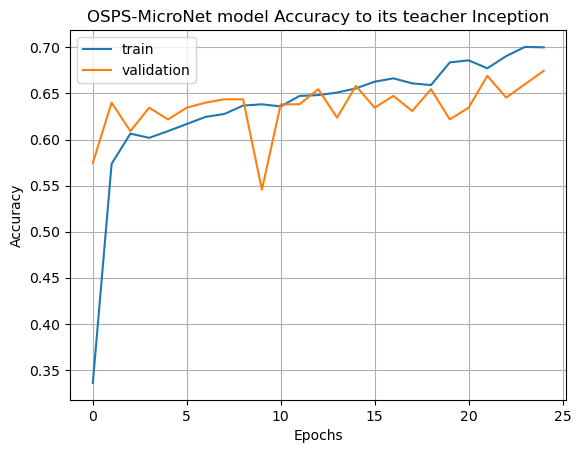

In [7]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher Inception')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [8]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher Inception model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher Inception model is 67.45454668998718


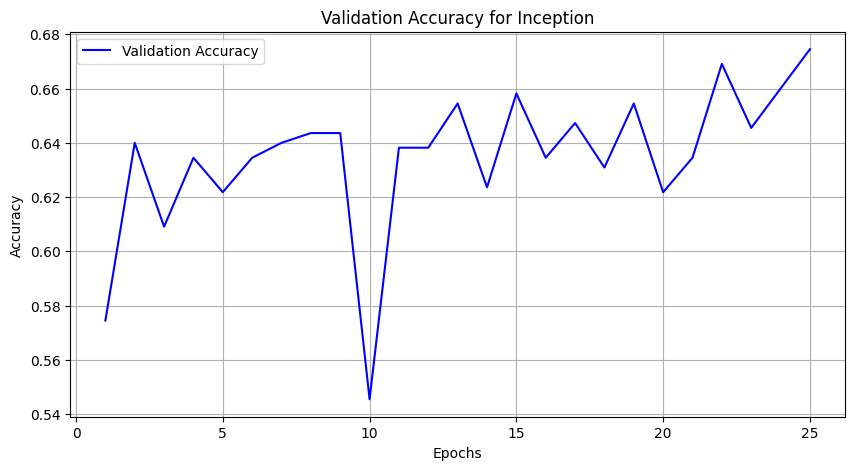

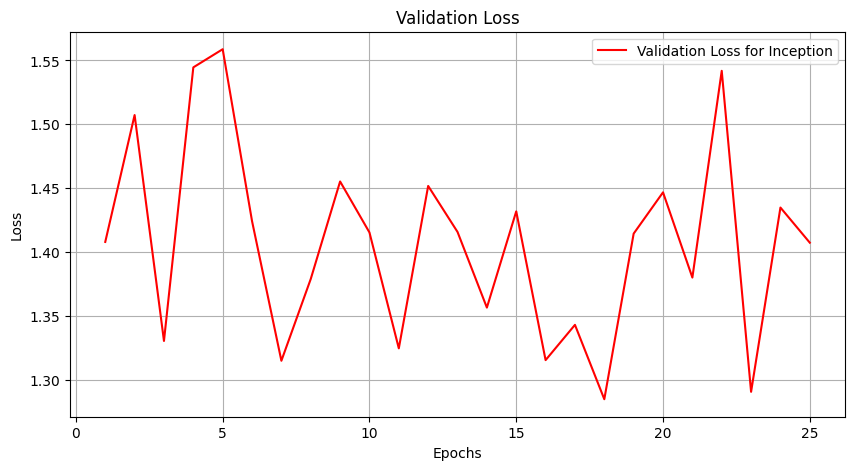

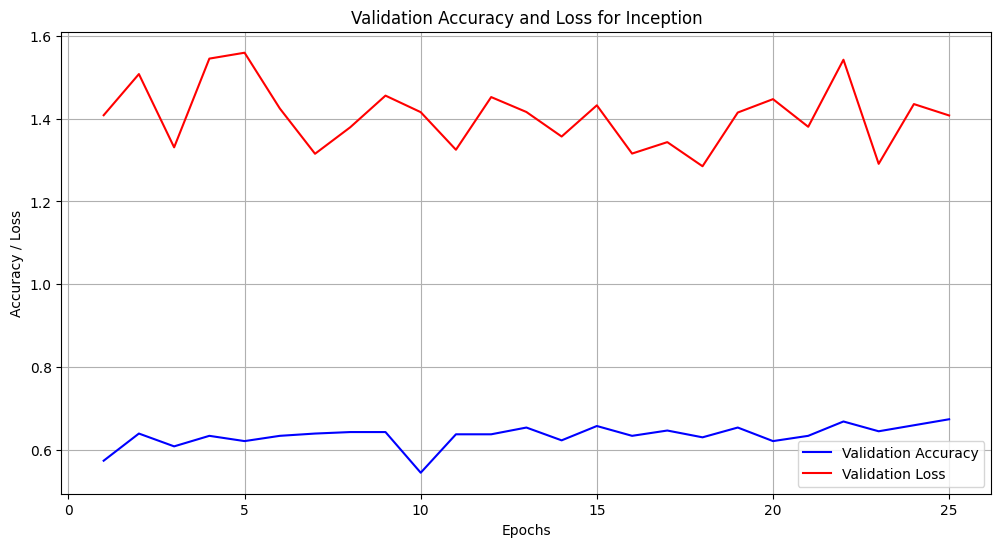

In [3]:
import matplotlib.pyplot as plt

epochs = range(1, 26)  # Number of epochs is 25 for the second dataset

# Validation accuracy and validation loss for the second dataset
val_accuracy = [0.5745, 0.6400, 0.6091, 0.6345, 0.6218, 0.6345, 0.6400, 0.6436, 0.6436, 0.5455, 
                0.6382, 0.6382, 0.6545, 0.6236, 0.6582, 0.6345, 0.6473, 0.6309, 0.6545, 0.6218,
                0.6345, 0.6691, 0.6455, 0.6600, 0.6745]

val_loss = [1.4080, 1.5073, 1.3305, 1.5446, 1.5588, 1.4243, 1.3150, 1.3790, 1.4553, 1.4154,
            1.3247, 1.4518, 1.4158, 1.3566, 1.4319, 1.3155, 1.3431, 1.2849, 1.4145, 1.4468,
            1.3801, 1.5419, 1.2907, 1.4349, 1.4074]

# Plotting Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Validation Accuracy for Inception')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, 'r', label='Validation Loss for Inception')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Validation Accuracy and Loss for Inception')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)
plt.show()
